# ICON 2017 workshop: MVPA of fMRI data in Python

Welcome to this workshop! In the upcoming couple of hours, you'll work through this (Jupyter) "notebook" - a sort of code editor in your browser that allows mixing of code (Python) and text (markdown) cells. Originally, this notebook was developed for the Research Master Psychology course [Neuroimaging: Pattern Analysis](http://studiegids.uva.nl/xmlpages/page/2017-2018/zoek-vak/vak/39531) at the University of Amsterdam, but it was adapted and extended for this ICON workshop.

### Scope
In general, this notebook is designed for people who are relatively *unfamiliar* with MVPA and/or its implementation in Python. We *do* assume that you are familiar with analyzing (f)MRI data; the purpose of this workshop is to "extend your analysis toolbox", so to say. As such, it’s definitely helpful if you have some knowledge about Python’s syntax, but it’s not strictly necessary. Also, we assume participants are relatively unfamiliar with machine learning (ML) concepts and their implementation; if you’re a ML guru, this is probably not the right workshop for you...

At certain points in the tutorial, we've included some more "advanced" material, but again, feel free to skip this. Also, realize that this tutorial is about the concepts behind MVPA and how to implement them using domain-general Python tools, such as [scikit-learn](http://scikit-learn.org). Importantly, this tutorial is **not** about how to use MVPA-specific frameworks such as [PyMVPA](http://www.pymvpa.org/) or [Nilearn](http://nilearn.github.io/), although we included a short section on [skbold](http://skbold.readthedocs.io), our own "machine learning for fMRI" package that is built around scikit-learn. 

Also, there is actually no single "multivoxel pattern analysis"; rather, MVPA is a bucket-term referring to several kinds of pattern-based analyses. As this tutorial cannot cover all such analyses, we limit the scope to machine learning (*classification-based*) analyses of fMRI data based on *within-subject* designs (leaving out between-subject decoding, regression-based analyses, unsupervised learing, etc.). We hope to cover these grounds sufficiently well for you to be able to explore other kinds of analyses own your own. 

### Learning goals of this workshop
In this workshop, we cover the basics of applying multivoxel pattern analysis (MVPA) to analyze (functional) MRI data in Python. After this tutorial, you are able to:

- Understand the differences between within-subject and between-subject pattern analysis;
- Know how to extract/estimate patterns from fMRI data;
- Implement different feature extraction and selection methods using scikit-learn;
- Build cross-validated MVPA pipelines using scikit-learn;
- Evaluate your models

In short, this tutorial will show how to build your own complete, cross-validated MVPA pipeline for fMRI data.

### Contents of this notebook
We designed this notebook to be interactive. That is, you'll encounter several "*ToDo*s" (yellow boxes) and "*ToThink*s" (blue boxes) that describe short programming exercises (ToDos) and questions for you to think about (ToThinks), which are aimed to improve understanding of the discussed so far. If you're not very comfortable with Python, or if you just don't feel like it, feel free to skip them, of course. Also, feel free to ask us questions during this workshop!

The tutorial is split in two parts. In the first part, we cover the basics of experimental designs, and illustrate how to extract patterns from raw fMRI data in a way that MVPA can be applied. In the second part, the major steps in MVPA (ML-based) pipelines is discussed: feature extraction and selection, cross-validation, and model evaluation. We challenge you to optimize your pipelines to maximize your decoding accuracy scores!

Have fun and good luck!

### Before you go on: did you download the data?
Did you already download the data, as described [here](http://lukas-snoek.com/ICON2017/)? Check it below!

In [4]:
import os
if os.path.isdir('../data'):
    print("You already downloaded the data! Continue with Part 1!")
else:
    print("Seems you don't have the data yet ... Go to lukas-snoek.com/ICON2017 for instructions on how to download it.")

You already downloaded the data! Continue with Part 1!


## Part 1: Experimental design, pattern estimation, and data representation
Before you can do any fancy machine learning analysis (or any other pattern analysis), there are several decisions you need to make and steps to take in (pre)processing and structuring your data. Roughly, there are three steps to take:

1. Design your study in a way that's appropriate to answer your question through a pattern analysis; this, of course, needs to be done *before* data acquisition!
2. Estimate/extract your patterns from the (functional) MRI data;
3. Structure and represent your data appropriately for pattern analyses;

While we won't go into all the design factors that make for an *efficient* pattern analysis (see [this article](http://www.sciencedirect.com/science/article/pii/S105381191400768X) for a good review), we will now discuss/demonstrate some design considerations and how they impact the rest of the MVPA pipeline.

### 1.1. Designs for pattern analysis
There are many ways in which you can categorize different types of pattern analyses, but one of the most basic categorizations is in terms of whether analyses are **within-subject** or **between-subject**. The major distinction revolves around whether you want to investigate an (experimental) factor that varies or is manipulated **within** subjects or that varies **across** subjects (i.e. individual differences or experimental between-subject designs)\*.

----
\* **N.B.**: there are also "hybrid" forms, such as when you decode a within-subject factor (e.g. "negative vs. positive images") from condition-average patterns across subjects. That is, each subject "contains" two patterns (one "negative image" pattern, one "positive image" pattern) and these patterns are decoded *across* subjects

<div class='alert alert-info'>
**ToThink**: Decide for the following scenarios whether they correspond to a **within-subject** or **between-subject** design!<br><br>

1. Subjects view a sequence of negative (violence, mutilation, war-scenes) images during fMRI acquisition. One group of subjects are administered [propanolol](https://en.wikipedia.org/wiki/Propranolol) before the fMRI session and another group a placebo. The researcher in charge wants to see whether patterns in the insula change in reponse to propanolol using a pattern-based analysis. <br><br>

2. Subjects view images of scenes with either animate of inanimate objects during fMRI acquisition. The researcher in charge wants to decode animacy in the lateral occipital cortex.
</div>

Importantly, these two types of analyses differ in what is regarded as an *instance of a pattern* (or: a *sample*):

- in **within**-subject analyses, *each instance of your feature-of-interest represents one pattern* (e.g., each single trial/stimulus/response);
- in **between**-subject analyses, *each subject represents one pattern*.

This distinction is important, because the choice of type of pattern analysis has major consequences for the design of your experiment and the methods available for pattern extraction. **Throughout this tutorial, we focus on within-subject analyses**, using a simple two-class working memory data-set.

### 1.2. Pattern estimation for within-subject designs
There are different ways to estimate your patterns for pattern-based analyses. Suppose you want to decode neural representations of faces from representations of houses. In that case, you need to to estimate a pattern for each face and each house. Now, suppose we show a face at 9 seconds, we can "extract" activity at each voxel for that stimulus in three ways (see figure below):

1. Extract just a point estimate of activity at, e.g., 6 seconds post-stimulus (expected HRF peak);
2. Average across a range of points;
3. Fit a HRF *per stimulus* and extract the corresponding $\beta$-parameter;

As method 3 (fitting a separate HRF per stimulus) has shown to yield the most stable pattern estimates ([Misaki et al., 2010](http://www.sciencedirect.com/science/article/pii/S1053811910007834)), we'll focus on that method in the rest of this section.

<img src="img/pattern_estimation.png" alt="Drawing" heigth="150" width="1000">

We will extract *patterns* of $\beta$-estimates by fitting a hemodynamic response function (HRF) per trial using the general linear model (GLM). In other words, "trials" (i.e. instances of your feature-of-interest) in within-subject designs are modelled as separate regressors in a first-level analysis. Below, we included an image of a single-trial design (of the hypothetical faces vs. houses experiment) as created in FSL:<img src="img/single_trial_design.png" alt="Drawing" heigth="100" width="500">

As you can see, each trial gets it's own regressor (hence the name "single-trial design"). Then, as depicted below the design matrix, a contrast-against-baseline is created for each regressor (trial). After you run a first-level analysis using this design, you'll have whole-brain maps containing statistics values ($\beta$-values, *t*-values, or *z*-values) for each trial that represent the trial's estimated (whole-brain) pattern. Usually, *t*-values or *z*-values are used instead of $\beta$-values (cf [Misaki et al., 2010](http://www.sciencedirect.com/science/article/pii/S1053811910007834)).

**Importantly, this design thus specifies that each "trial" represents a sample with its own pattern (voxel-activities).**

Before you go on, make sure you understand this image! This image represents basically all you need to understand about single-trial designs. 

### 1.3. Implementing a single-trial design
To further illustrate how single-trial designs work, let's create your own single-trial matrix corresponding to a (real) working memory experiment. In this experiment, one condition ("ACTIVE") required subjects to remember a configuration of bars, and after a retention period had to respond whether one of the bars has changed in the test-image or not. In the other condition ("PASSIVE") they just watched a blank screen and had to respond with a random answer. The experiment is depicted schematically below:

![test](img/WM_example.png) 

In total, subjects performed 40 trials, of which 32 were of the "ACTIVE" condition and 8 were of the "PASSIVE" condition**\***. Next, we'll generate a single-trial design that aims to estimate the pattern for each trial.

---
**\* Note**: this data-set was not necessarily meant to be analysed with MVPA, as it has some sub-optimal factors w.r.t. pattern analysis, such as class-imbalance (32 active vs. 8 passive trials) and all "instances" (trials) contained in a single run, while it is often recommended to spread out your trials across different runs (see e.g. [this study](http://www.sciencedirect.com/science/article/pii/S1053811912003643)), which will be shortly discussed in section 2.4. (on cross-validation).

Below, we'll load the trial onset times (and trial durations and conditions).

In [78]:
# First, we need to import some Python packages
import numpy as np
import pandas as pd
import os.path as op
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

In [79]:
# The onset times are loaded as pandas dataframe with three columns: 
# onset times (in seconds) (column 1), durations (column 2), and conditions (column 3).
# N.B.: condition 0 = passive, condition 1 = active
onsets = pd.read_csv(op.join('example_data', 'onsets.csv'), sep='\t', names=['onset', 'duration', 'trial_type'])
onsets

,onset,duration,trial_type
0,8,6,1
1,20,6,1
2,26,6,1
3,36,6,0
4,42,6,1
5,52,6,1
6,60,6,1
7,66,6,1
8,72,6,1
9,78,6,1


Remember, the onsets (and duration) are here defined in seconds (not TRs). Let's assume that the fMRI-run has a TR of 2. Now, we can convert (very easily!) the onsets/durations-in-seconds to onsets/durations-in-TRs.

In [45]:
onsets[['onset', 'duration']] = (onsets[['onset', 'duration']] / 2).astype(int)

To perform the first-level analysis, for each regressor (trial) we need to create a regressor of zeros and ones, in which the ones represent the moments in which the particular trial was presented. Let's assume that our moment of interest is the encoding phase, which lasts only 2 seconds; we thus can model it as an "impulse".

So, for example, if you have a (hypothetical) run with a total duration of 15 TRs, and you show a stimulus at TR=3 for the duration of 1 TRs (i.e. 2 seconds), then you'd code your regressor as:

`[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]`

<div class='alert alert-warning'>
**ToDo**: Below, we initialized a stimulus vector (`stim_vec`) of shape=[162, 40], i.e. timepoints x trials (this run was 162 TRs long), with zeros. Each of the 40 rows represents one trial. Loop over the colums of the `stim_vec` matrix and fill the times at onset till the onset + 2 TRs with ones. Remember, the first index in Python is zero (not 1!).
</div>

In [57]:
# Fill the stim_vec variable with ones at the indices of the onsets per trial!
n_trials = 40
stim_vec = np.zeros((162, n_trials))

for itrial in range(n_trials):
    idx = onsets['onset'][itrial]
    stim_vec[idx, itrial] = 1

Now, we only need to convolve an HRF with the stimulus-vectors and we'll have a complete single-trial design! Don't worry, we do this for you. We'll also plot it to see how it looks.

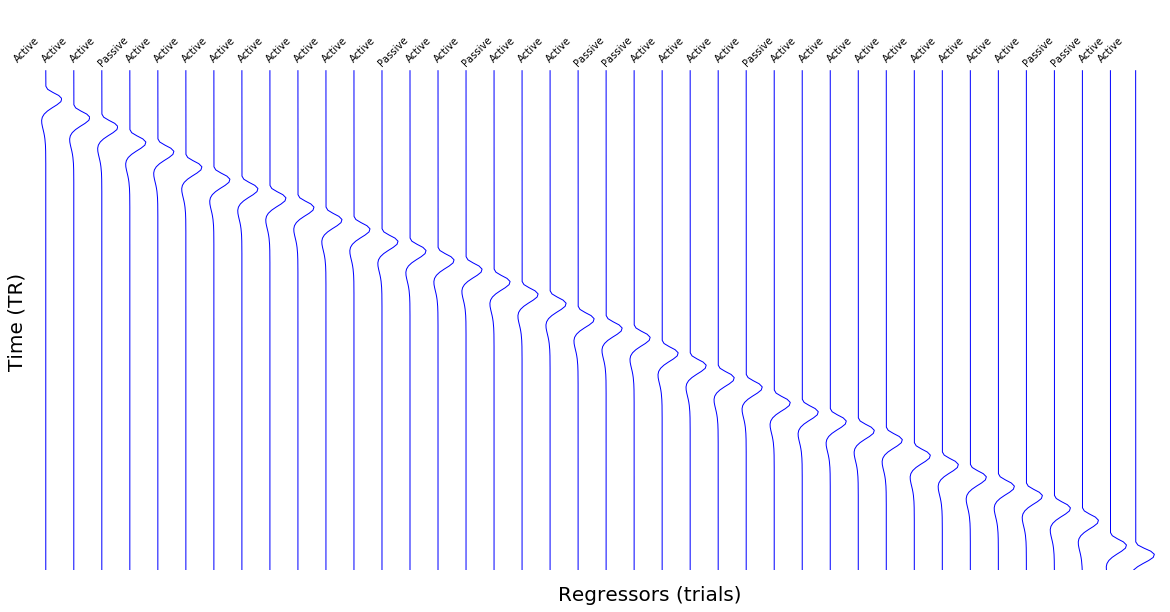

In [56]:
from functions import double_gamma

hrf = double_gamma(range(162))

# List comprehension (fancy for-loop) + stack results back to a matrix
X = np.vstack([np.convolve(hrf, stim_vec[:, i], 'full')[:162] for i in range(40)]).T

plt.figure(figsize=(20, 10))
for plot in range(40):
    plt.subplot(1, 40, plot+1)
    plt.plot(X[:, plot], range(X.shape[0])[::-1])
    plt.axis('off')
    plt.text(-2, 170, 'Active' if onsets['trial_type'][plot] == 1 else 'Passive', rotation=45)

plt.text(-25, -10, 'Regressors (trials)', ha='center', fontsize=20)
plt.text(-58, 80, 'Time (TR)', va='center', rotation='vertical', fontsize=20)
plt.show()

We could use this design to extract patterns of $\beta$-values for each regressor. But [it has been shown](http://www.sciencedirect.com/science/article/pii/S1053811910007834) that converting $\beta$-values to *t*-values often creates more stable and robust patterns. $\beta$-values can be normalized to *t*-values by simply dividing the parameter estimate ($\beta$) by it's corresponding standard error, which we're sure you know how to do.

So, now you know how to create a "single-trial design" for pattern analyses! As a short summary:
- Model each "trial" (or more generally, "instance") as a separate HRF-convolved regressor;
- Additionally define a contrast-matrix in which each trial is contrasted against baseline in order to create *t*-value/*z*-value patterns;

<div class='alert alert-warning'>
**ToDo**: We ran the first-level analysis of the single-trial working-memory design outlined above for fifteen subjects using FSL. You can find the results in the directory: `../data/{subject_number}/wm.feat`. Pick one of the subjects, and check out the `stats` subdirectory. You will see forty tstat-niftis, each containing a whole-brain pattern of *t*-stats of a single trial. These contain the data we will use in this tutorial for MVPA.
</div>

Alright, you now know what a single-trial (within-subject) design looks like and what it produces (i.e. single-trial pattern estimates in the form of whole-brain $\beta$/*t*-stat/*z*-stat maps). Before we go on, we will show what a pattern of a single trial looks like in fslview. This will hopefully give you some more "intuition" on what is meant with a single trial pattern. 

<div class='alert alert-warning'>
**If you have FSL installed on your computer, you can do this yourself!** open up a new terminal or terminal-tab and start fslview (by typing `fslview` in the terminal). Now, click "File" > "Open", navigate to `data/pi0070/wm.feat/stats` and select `tstat1.nii.gz`. Now, to visualize the patterns somewhat more intuitively, set in the fslview header "Min" to 0 and "Max" to 5. Then, click the little circle with the blue "i": <img src="img/viz.png">
<br>
Under the "lookup table options", select the "Red-Yellow" colormap. What you visualize here are all the voxels that activate during this particular trial. However, a pattern is not necessarily only the voxels that *activate*, but also those that *deactivate*. A pattern is *any* estimated response of the brain during an instance of a sample (here: a trial). Therefore, let's also visualize the deactivating voxels. To do so, click "File" > "Add" and select the `tstat1.nii.gz` image *again*, but now set "Min" to 0 and "Max" to -5. For this file, select the colormap "Blue-Lightblue". 

What you should see now is something like this: <img src="img/screenshot_within.png">

<br>
What we visualized here is an example of a within-subject pattern of a particular trial ("sample"), in which the activated voxels (relative to baseline) are colored red/yellow, and the deactivated voxels (relative to baseline) are colored blue/lightblue. Make sure you understand how this image represents the pattern of a single sample.
</div>

### 1.4. Data representation
In pattern analyses, there is a specific way to 'store' and represent brain patterns: as 2D matrices of shape N-samples $\cdot$ K-voxels. **Important**: often (and confusingly), people refer to voxels as (brain) 'features' in pattern analyses. So in articles people often refer to samples-by-features matrices!

Anyway, this is what such a matrix looks like: 
![](img/data_representation.png)

Each row thus represents the voxel pattern of a sample (or: an "instance")!

As you can see, the originally 3D voxel patterns (e.g. whole-brain patterns of *t*-values) are flattened (also called "vectorized" or "raveled") such that we can stack all patterns vertically into a 2D matrix. There are two reasons why pattern analyses need this 2D format and thus discard spatial information about the voxel patterns:
 
1. There are very few analyses that take spatial information into account in the first place (so by flattening we get rid of the spatial information); 
2. Most algorithms used "under the hood" by pattern analyses rely heavily on matrix algebra (which operate on 2D matrices by definition).

Anyway, let's look at an example. We're going to work with the working-memory data (as outline in the beginning of the notebook). Suppose we want to investigate whether we can predict whether a trial is passive or active (factor: working memory load) from (whole-brain) voxel patterns. Consequently, this is a **within-subject design**. As such, we model each trial separately by fitting a single-trial design matrix to obtain patterns of *t*-values per trial (similar to the plot just before Section **1.3**). The results are in the directory: `data/pi0031/wm.feat`. Check out the directory (again) and especially the stats-folder. You should see a bunch of nifti-files which contain 3D voxel patterns with "tstat" values (FSL also produces pes [betas], copes, varcopes - we removed these to minimize data size of this tutorial).

For this analysis, we're going to use patterns of *t*-stats (as is generally recommended over $\beta$s).<br>
As you can see, there are 40 nifti-files with *t*-stats; these refer to the 40 trials in the experiment (32 active trials, 8 passive trials)! Given that we need to adhere to the data representation as outlined above, we are in the following situation:

**What we have**: 40 (3D) nifti-files<br>
**What we need**: one 2D numpy array of shape 40 x {whatever amount of voxels there are in those niftis}

Alright, time to learn some Python gems that help us load in and transform those patterns into a usable 2D numpy matrix.

#### 1.4.1 tips & tricks to load and transform (nifti-)files
As a first thing, we need to find all the paths to the *t*-stat nifti-files. Python has a nifty (pun intended) tool called "`glob`" which can find files/directories on disk using [wildcards](https://en.wikipedia.org/wiki/Wildcard_character). It is usually imported as follows:

In [58]:
from glob import glob

`glob`, in Python, is a function that takes a path (as a string) with one or more wildcard characters (such as the `*`) and searches for files/directories on disk that match that. For example, let's try to find all the png-imagesin the "img" directory using glob (these are the images that I used inside this notebook). 

In [80]:
import os
my_search_string = 'img' + os.sep + '*.png'
png_files = glob(my_search_string)
print(png_files)

['img/within_subject_example.png', 'img/WM_example.png', 'img/pattern_estimation.png', 'img/fslview.png', 'img/viz.png', 'img/sklearn_transformers.png', 'img/obj_class_diff.png', 'img/pipelinesX.png', 'img/screenshot_within.png', 'img/single_trial_design.png', 'img/data_representation.png']


As you can see, it returns a list with all the files/directories that matched the search-string. Note that you can also search files outside of the current directory. To do so, we can simply specify the relative or absolute path to it.

<div class='alert alert-warning'>
**ToDo**: Now you have the skills to actually "glob" all the *t*-stats from subject `pi0070` yourself! Use glob to find all the paths to the t-stats and store the results (a list with 40 strings) in a variable called `tstat_paths`. Note: the data directory is one directory above the current directory! Hint: watch out! There might be an `ftest.nii.gz` file in the stats-directory ...
</div>

In [81]:
# Example answer
tstat_paths = glob('../data/pi0070/wm.feat/stats/tstat*.nii.gz')

In [92]:
# To check your answer, run this cell
assert(len(tstat_paths) == 40)
print("Well done! You globbed all the 40 tstat-files correctly!")

Well done! You globbed all the 40 tstat-files correctly!


**Warning**: `glob` returns unsorted paths (so in seemingly random order). It's better if we sort the paths before loading them in, so the order of the paths is more intuitive (the first file is tstat1, the seconds tstat2, etc.). Python has a builtin function `sorted()`, which takes a list and sorts it alphabetically. The problem, here, is that if we'd use that - i.e. `sorted(tstat_paths)` - it will actually sort the files as: tstat1, tstat10, tstat11, etc. See for yourself: 

In [82]:
print(sorted(tstat_paths))

['../data/pi0070/wm.feat/stats/tstat1.nii.gz', '../data/pi0070/wm.feat/stats/tstat10.nii.gz', '../data/pi0070/wm.feat/stats/tstat11.nii.gz', '../data/pi0070/wm.feat/stats/tstat12.nii.gz', '../data/pi0070/wm.feat/stats/tstat13.nii.gz', '../data/pi0070/wm.feat/stats/tstat14.nii.gz', '../data/pi0070/wm.feat/stats/tstat15.nii.gz', '../data/pi0070/wm.feat/stats/tstat16.nii.gz', '../data/pi0070/wm.feat/stats/tstat17.nii.gz', '../data/pi0070/wm.feat/stats/tstat18.nii.gz', '../data/pi0070/wm.feat/stats/tstat19.nii.gz', '../data/pi0070/wm.feat/stats/tstat2.nii.gz', '../data/pi0070/wm.feat/stats/tstat20.nii.gz', '../data/pi0070/wm.feat/stats/tstat21.nii.gz', '../data/pi0070/wm.feat/stats/tstat22.nii.gz', '../data/pi0070/wm.feat/stats/tstat23.nii.gz', '../data/pi0070/wm.feat/stats/tstat24.nii.gz', '../data/pi0070/wm.feat/stats/tstat25.nii.gz', '../data/pi0070/wm.feat/stats/tstat26.nii.gz', '../data/pi0070/wm.feat/stats/tstat27.nii.gz', '../data/pi0070/wm.feat/stats/tstat28.nii.gz', '../data/pi007

To fix this issue, we wrote a little function (`sort_nifti_paths()`) that sorts the paths correctly. (If you're interested in how it works, check out the functions.py file.)

In [83]:
# Let's fix it
from functions import sort_nifti_paths
tstat_paths = sort_nifti_paths(tstat_paths)

#### 1.4.2. Loading in nifti-data using nibabel

Now, we have the paths to all the nifti-files of a single subject. To load a nifti-file into a numpy-array in Python, we can use the awesome [nibabel](http://nipy.org/nibabel) package. This package has two useful methods you can use to load your data: `load` and `get_data`. You need to use them consecutively to load the *t*-values in memory. For example, to load the whole-brain pattern of *t*-values of the first trial of subject pi0070:

In [89]:
import nibabel as nib
data = nib.load('../data/pi0070/wm.feat/stats/tstat1.nii.gz').get_data()

<div class='alert alert-warning'>
**ToDo**: in the code block below, write a loop that loads in the tstat nifti-files one by one (using nibabel) and store them in the already preallocated array "X". Note that "X" is a 2D matrix (samples-by-features), but each tstat-file contains a 3D array, so you need to "flatten" the 3D array to a single vector: use e.g. the numpy function "flatten()" or "ravel()". 
</div>

In [90]:
voxel_dims = (80, 80, 37) # The data is in EPI-space
X = np.zeros((len(tstat_paths), np.prod(voxel_dims)))

# Example answer
for trial, tstat_path in enumerate(tstat_paths):
    data = nib.load(tstat_path).get_data()
    data = data.ravel()
    X[trial,:] = data

#### Check your ToDo
Run the cell below to see whether you implemented the ToDo below correctly. If you don't get errors, you did it correctly!

In [94]:
# Can we check if X is correct here? Would be a good check before continuing to part 2
np.testing.assert_almost_equal(X, np.load('example_data/X_section1.npy'))
print("Well done!")

Well done!


### You've reached a milestone!
Starting with 4D fMRI data, you now have patterns in the right format (a 2D-matrix of N-samples x N-features). Now, let's start talking about machine learning!

## Part 2. Multivoxel pattern analysis
In Part 1, we discussed within-subject single-trial designs, and showed how to load single-trial data in the right format to perform MVPA. It's now time to actually implement machine learning analyses!

We'll be looking at the implementation of concepts like K-fold cross-validation, feature-selection/extraction, model fitting/prediction, permutation testing, and feature visualization. To do so, we'll use the [`scikit-learn`](http://scikit-learn.org) machine learning package in Python (the de-facto and most-used ML package in Python).

Remember that, very generally, MVPA is all about inferring a feature-of-interest (dependent variable) using patterns of fMRI data. Let's call the feature-of-interest **y**, and the patterns of fMRI data **X**. This inference from X to y is called *decoding*: we want to *decode* a dependent variable y from X.

In our case, let's continue with the data from the working memory experiment used in Part 1. Remember that, in this experiment, participants performed two types of trials: "ACTIVE" trials, in which they had to remember the orientation of eight bars, and "PASSIVE" trials in which they did not do anything (note that the screen shortly flickered in the "PASSIVE" trials in order to activate the visual cortex). Let's try to decode trial type from the patterns of *t*-values you creates in Part 1!

### 2.1 Adding the dependent variable y
In Section 1.3, you ended with a nice 2D-matrix of N-samples x N-features. This 2D-matrix contains all whole-brain patterns of *t*-values for all trials: this is your **X**. However, this leaves out a crucial part of the data: the actual feature-of-interest, *trial type*, your **y**.

While there is kind of a generic way to load in voxel patterns, there is usually not a single way to load in your dependent variable (y), because the exact factor that represents `y` dependent on your exact research question (and also depends how you have stored this data on disk). 

In within-subject single-trial designs, trial type or condition is often the dependent variable. The dependent variable can thus be extracted from your design. In fact, we already loaded the dependent variable previously, in the `onsets` variable (see Section 1.2). The third column named 'trial_type') contains the trial types, where 1 is an "ACTIVE" trial and 0 a "PASSIVE" trial.

<div class='alert alert-warning'>
**ToDo**: Extract vector *y* from `onsets`, which only contains the trial types (i.e., y = [1, 1, 1, 0, ..., 0, 1, 1]) 
</div>

In [98]:
y = onsets['trial_type'].tolist()

#### 2.1.1 Intermezzo (optional, and slightly commercial): `skbold`

# Dit moeten we denk ik helemaal naar achteren halen  

The steps described above showed how to load a pattern of fMRI data into a 2D-matrix that will allow you to perform pattern analyses. These steps might seem cumbersome, but they can get more complex. For example, the data is currently loaded in EPI-space, and you might want to register them to MNI-space. Or, you might want to apply an anatomical mask (e.g., a grey matter mask, or a ROI). Or maybe you are interested in between-subject analyses. Such additional steps increase the complexity of loading your data.

However, there is a huge advantage of using programming languages such as Python: they are open source, and there are many code packages available to help you out with problems that others have faced and solved before you. Luckily, there is also a package that will help you do your pattern analyses: [`skbold`](https://github.com/lukassnoek/skbold), created by the authors of this workshop.

In fact, everything that you have done so far can be done using the following 5(-ish) lines of code:

In [110]:
from skbold.core import MvpWithin

feat_dir = '../data/pi0070/wm.feat'
ref_space = 'epi' # extract patterns in functional space (alternatively: 'mni')
statistic = 'tstat'

mvp = MvpWithin(source=feat_dir, ref_space=ref_space, statistic=statistic)
mvp.create() # extracts and stores (meta)data from FEAT-directory!
mvp.y

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0])

After running this code, mvp.X contains your pattern, and mvp.y contains the to-be-decoded labels. That was easy! `skbold` also allowed you to perform some other frequently performed steps. For example, the following code reads in the labels of your dependent variable y, it applies a grey matter mask, removes some contrasts we're not interested in (from nuisance regressors), and removes voxels that have the value 0 in all conditions (and therefore cannot contain any information about y).

In [111]:
from skbold.core import MvpWithin

feat_dir = '../data/pi0031/wm.feat'
mask_file = '../GrayMatterMask.nii.gz' # mask all non-gray matter!
read_labels = True # parse labels (targets) from design.con file!
remove_contrast = ['nuisance_regressor_x'] # do not load nuisance regressor!
ref_space = 'epi' # extract patterns in functional space (alternatively: 'mni')
remove_zeros = True # remove voxels which are zero in each trial

mvp = MvpWithin(source=feat_dir, read_labels=read_labels,
                remove_contrast=remove_contrast, ref_space=ref_space,
                remove_zeros=remove_zeros,
                mask=mask_file)

mvp.create() # extracts and stores (meta)data from FEAT-directory!

FileNotFoundError: No such file: '../GrayMatterMask.nii.gz'

Obviously, you could code all this yourself - in fact, from an educative perspective, that is a very good thing to do. However, for real analyses, it might be useful to use open source code others have written before you. There's no need to re-invent the wheel!

### 2.2. An overview of a typical machine learning pipeline
Awesome, we now have everything we need (X and y). This took a while, but you'll soon see it was worth the effort.

In the rest of the tutorial, you'll finally learn how to actually implement decoding pipelines. Typical pipelines consist of the following elements:

* Data partitioning
* Feature selection/extraction
* Model fitting (on train-set)
* Model cross-validation (on test-set)
* Calculate model performance
* Statistical analyses of performance
* Optional: feature visualization 

In the rest of the tutorial, we'll discuss these topics in a slightly different order. First, we'll discuss how you can fit and cross-validate scikit-learn models, and while we're at it, how to calculate model performance (here: accuracy). Subsequently, you'll learn how to embed these concepts in fully cross-validated K-fold data partitioning schemes. Finally, we'll extend our pipelines with feature selection methods. 

### 2.3. Model fitting & cross-validation
First, we'll show you how to use scikit-learn models. In fact, the most useful functionality of scikit-learn is probably that they made fitting and cross-validating models (or, in scikit-learn lingo: estimators) trivially easy. 

Note that in the upcoming example, we will fit the model on *all* our samples. In practice, this is something you would *never* do: you always need to cross-validate your model to a new, independent sample (i.e., independent with respect to noise: the noise in your *training* sample should not be correlated with the noise in your *test* set).

Anyway, let's import a scikit-learn model: the (linear) support vector classifier ([SVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)), which is one of the most-often used models in fMRI pattern analyses. In scikit-learn, this model is part of the (suprising...) `svm` module:

In [112]:
# Scikit-learn is always imported as 'sklearn'
from sklearn.svm import SVC

Like most of scikit-learn's functionality, SVC is a *class*. Let's initialize an SVC-object! One important argument that this object needs is the ["kernel"](http://scikit-learn.org/stable/auto_examples/svm/plot_svm_kernels.html) you want the model to have. Basically, the kernel determines how to treat/process your features: linearly, or non-linearly (such as the `kernel='rbf'` or `kernel='poly'` options). Most often a linear kernel is the best option (as non-linear kernels seem to overfit very quickly).

To initialize an SVC-object with a linear kernel, just do as follows:

In [113]:
# clf = CLassiFier
clf = SVC(kernel='linear')

Alright, we initialized an SVC-object with a linear kernel. Now, you need to do two thing to get the prediction for each sample (i.e. whether they're predicted as 0 or 1): fit, using the method `fit(X, y)`, and predict the class (i.e. 0 or 1) for each class using the method `predict(X)`. Basically, in the `fit` method, the parameters of the model (i.e. $\beta$) are estimated. Then, in the `predict` method, the estimated parameters are used to generate a prediction for each sample (i.e. 0 or 1). 

Let's first look at the `fit` method. As you can see, the `fit(X, y)` method with two parameters: X (a samples-by-features matrix) and y (a vector of length n-samples). Let's do that for our data: 

In [114]:
clf.fit(X, y)
print('Fitted SVC...')

Fitted SVC...


After calling the fit() method, the clf-object contains an attribute `coef_` that represent the model's parameters ('coefficients' in scikit-learn lingo, i.e. $\beta$). Let's check that out:

In [115]:
coefs = clf.coef_
print("Shape of coefficients: %r" % (coefs.shape,))

Shape of coefficients: (1, 236800)


Ah, just like we expected: the `coef_` attribute is exactly the same size as the number of voxels in our X-matrix (i.e. 80\*80\*37). 

Anyway, usually, you don't do anything directly with the weights (perhaps only if you want to do anything with feature visualization): scikit-learn handles that for you. What you *do* want, is an actual prediction ($\hat{y}$) for our samples!

To get this, simply call the `predict(X)` method of the model, which returns the predictions as an array:

In [116]:
y_hat = clf.predict(X)
print("The predictions for my samples are:\n %r" % y_hat)

The predictions for my samples are:
 array([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1])


A logical next step is to assess how good the model was in predicting the class of the samples. A straightforward metric\* to summarize performance is *accuracy* which can be defined as: 

\begin{align}
accuracy = \frac{number\ of\ correct\ predictions}{number\ of\ predictions}
\end{align}

---------------
\* There are waaaay [more metrics to summarize model performance](http://machinelearningmastery.com/classification-accuracy-is-not-enough-more-performance-measures-you-can-use/) for classification models, such as precision, recall, F1-score, and ROC-AUC. These metrics are more appropriate than accuracy when you have *imbalanced classes*, i.e. more samples in one class (e.g. negative images) than in another class (e.g. positive images). Usually, however, experimental designs in fMRI pattern analyses are (more of less) balanced, so often you can just use accuracy. More on this in Section **2.6**!

<div class='alert alert-warning'>
**ToDo**: Can you calculate the accuracy of the above model? Hint 1: you need to compare the true labels (i.e. mvp.y) with the predicted labels (i.e. y_hat). Hint 2: if you do arithmetic with boolean values (i.e. `True` and `False`), `True` is interpreted as 1 and `False` is interpreted as 0.
</div>

In [118]:
# Implement your to-do here!
accuracy = (y_hat==y).mean()
print(accuracy)

1.0


If you've done the ToDo above correctly, you should have found out that the accuracy was 1.0 - a perfect score! "Awesome! Nature Neuroscience material!", you might think. But, as is almost always the case: if it's too good to be true, it probably *is* indeed too good to be true.

So, what is the issue here? Well, we didn't cross-validate the model! We fitted it on all the samples in the mvp-object and predicted the *same* samples, which leads to optimistic estimate of model performance. Such optimistic estimates in uncross-validated models are especially likely when there are many more features (here: voxels) than samples (here: subjects). In other words, we are probably *overfitting* the model here.

Thus, let's check what happens if we actually cross-validate the model. To do so, we need to partition the data into a train- and test-set. For this example, we'll use a simple hold-out scheme, in which we'll reserve half of the data for the test-set (we'll discuss more intricate cross-validation schemes such as K-fold in the next section).

Below, we index `X` and `y` such that the train-set will contain all odd-numbered samples and the test-set will contain all even-number samples:

In [119]:
X_train = X[1::2]
print("Shape X_train: %r" % (X_train.shape,))

y_train = y[1::2]
print("Shape y_train: %r" % (y_train.shape,))

X_test = X[0::2]
print("Shape X_test: %r" % (X_test.shape,))

y_test = y[0::2]
print("Shape y_test: %r" % (y_test.shape,))

Shape X_train: (20, 236800)


AttributeError: 'list' object has no attribute 'shape'

<div class='alert alert-warning'>
**ToDo**: now it's up to you to actually implement the *cross-validated* equivalent of the fit/predict procedure we showed you before. So, fit your model on `X_train` and `y_train` and then predict `X_test`. Calculate the cross-validated accuracy by comparing the predictions with `y_test`. 
</div>

In [34]:
# Implement your ToDo here

# Example answer
mod = clf.fit(X=X_train, y=y_train)
y_test_hat = clf.predict(X=X_test)
accuracy = np.sum(y_test_hat==y_test) / len(y_test)
print(accuracy)

0.85


Sweet! You actually performed your first proper decoding analysis in the ToDo above! There are however a couple of things we can do to improve the efficiency and results. One thing we can do is to use the data more efficiently in cross-validation. In the previous example, we split the data into two sets and fit the model on one (the train-set) and cross-validated to the other (the test-set). There is actually a way to "re-used" the data by using K-fold cross-validation, in which data is iteratively partitioned in train- and test-sets. This is explained in the next section.

### 2.4 Data partitioning: K-fold cross-validation
There are two principled ways of cross-validation: 

* Hold-out cross-validation;
* K-fold cross-validation;

In the previous section we implemented a form of hold-out cross-validation, which can be seen as a kind of "one-shot cross-validation". In fMRI data-sets, however, we usually have few samples (simply because MRI-data is expensive to acquire!). Because K-fold cross-validation allows you to reuse the data, it is much more common than hold-out cross-validation in MRI studies.

Now, we can finally use some of scikit-learn's functionality. We are going to use the [StratifiedKFold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) object from scikit-learn's model_selection module. Click the highlighted link above and read through the manual to see how it works.

Importantly, if you're dealing with a classification analysis, always use *Stratified*KFold (instead of the regular [KFold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html)), because this version makes sure that each fold contains the same proportion of the different classes (here: 0 and 1). Anyway, enough talking. Let's initialize a StratifiedKFold object with 5 folds:

In [35]:
# scikit-learn is imported as 'sklearn'
from sklearn.model_selection import StratifiedKFold

# They call folds 'splits' in scikit-learn
skf = StratifiedKFold(n_splits=5)

Alright, we have a StratifiedKFold object now, but not yet any indices for our folds (i.e. indices to split X and y into different samples). To do that, we need to call the `split(X, y)` method:

In [36]:
folds = skf.split(X, y)

Now, we created the variable `folds` which is officially a [generator](https://wiki.python.org/moin/Generators) object, but just think of it as a type of list (with indices) which is specialized for looping over it. Each entry in `folds` is a tuple with two elements: an array with train-indices and an array with test-indices. Let's demonstrate that\*:

-------------
\* Note that you can only run the cell below once. After running it, the `folds` generator object is "exhausted", and you'll need to call `skf.split(mvp.X, mvp.y)` again in the above cell.

In [37]:
i = 1
for fold in folds:
    
    print("Processing fold %i" % i)
    # Here, we unpack fold (a tuple) to get the train- and test-indices
    train_idx = fold[0]
    test_idx = fold[1]
    
    print("Train-indices: %s" % train_idx)
    print("Test-indices: %s\n" % test_idx)
    
    i += 1
i = 0

Processing fold 1
Train-indices: [ 7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31
 34 35 36 37 38 39]
Test-indices: [ 0  1  2  3  4  5  6 32 33]

Processing fold 2
Train-indices: [ 0  1  2  3  4  5  6 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31
 32 33 36 37 38 39]
Test-indices: [ 7  8  9 10 11 12 13 34 35]

Processing fold 3
Train-indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 38 39]
Test-indices: [14 15 16 17 18 19 36 37]

Processing fold 4
Train-indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 26 27 28 29 30
 31 32 33 34 35 36 37 39]
Test-indices: [20 21 22 23 24 25 38]

Processing fold 5
Train-indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 32 33 34 35 36 37 38]
Test-indices: [26 27 28 29 30 31 39]



As you can see, StratifiedKFold determined that for the first fold, sample 1 to 9 should be used for training and sample 0 and 2 (remember, Python uses 0-based indexing!) should be used for testing.

Now, we know how to access the train- and test-indices, but we haven't *actually* indexed our X and y (i.e. mvp.X and mvp.y) in the for-loop over folds. Nor have we actually fit the model on the train-set and cross-validated this to the test-set.

<div class='alert alert-warning'>
**ToDo**: in the code-cell below, complete the statements by indexing X and y to create four different objects in every fold: X_train, y_train, X_test, y_test. Also, we created a new classifier-object (clf) for you based on a different model: scikit-learn's `LogisticRegression` to show you that *every* model in scikit-learn works the same. Use this classifier to fit on the train-set and predict the test-set in every fold. Then, calculate the (cross-validated) accuracy in every fold. Keep track of the accuracies across folds, and after the loop over folds, calculate the average accuracy across folds.
</div>

In [38]:
from sklearn.linear_model import LogisticRegression

# clf now is a logistic regression model
clf = LogisticRegression()
# run split() again to generate folds
folds = skf.split(X, y)

accuracy = []

for fold in folds:
    
    # This is a slightly more concise way to unpack tuples
    train_idx, test_idx = fold
    
    # Complete these statements by indexing X and y with train_idx and test_idx
    X_train = 
    y_train = 
    
    X_test = 
    y_test = 
    
    # ToDo: call fit (on train) and predict (on test)
    
    # ToDo: calculate accuracy

# ToDo: calculate average accuracy


SyntaxError: invalid syntax (<ipython-input-38-363bf77f3765>, line 16)

In [39]:
# EXAMPLE AMSWER
from sklearn.linear_model import LogisticRegression

# clf now is a logistic regression model
clf = LogisticRegression()
# run split() again to generate folds
folds = skf.split(X, y)

accuracy = []

for fold in folds:
    
    # This is a slightly more concise way to unpack tuples
    train_idx, test_idx = fold
    
    # Complete these statements by indexing X and y with train_idx and test_idx
    X_train = X[train_idx,:]
    y_train = y[train_idx]
    
    X_test = X[test_idx,:]
    y_test = y[test_idx]
    
    # ToDo: call fit (on train) and predict (on test)
    model = clf.fit(X=X_train, y=y_train)
    y_hat = model.predict(X=X_test)
    
    # ToDo: calculate accuracy
    accuracy.append(np.sum(y_hat==y_test)/len(y_test))

# ToDo: calculate average accuracy
print('Mean accuracy: %.3f' % np.mean(accuracy))

Mean accuracy: 0.851


Implementing K-fold cross-validation instead of hold-out cross-validation allowed us to make our analysis a little more efficient (by reusing samples). Another method that (usually) improves performance in decoding analyses is feature selection/extraction. 

## 2.5. Feature selection/extraction
As discussed before, a small sample/feature-ratio often results in overfitting (optimistic performance estimates on train-set). It follows then that reducing the amount of features often has a beneficial effect on cross-validated performance estimates.

Feature reduction can be achieved in two principled ways:

* feature extraction: transform your features into a set of lower-dimensional components;
* feature selection: select a subset of features

Examples of feature extraction are PCA (i.e. transform voxels to orthogonal components) and averaging features within brain regions from an atlas. Because feature extraction often does not use any information from the labels (`y`), this step does not need to be cross-validated (but you *can* cross-validate, e.g., PCA by estimating the components on the train-set only). 

Examples of feature selection are ROI-analysis (i.e. restricting your patterns to a specific ROI in the brain) and "univariate feature selection" (UFS). This latter method is an often-used data-driven method to select features based upon their univariate difference. 

Fortunately, scikit-learn has a bunch of feature selection/extraction objects for us to use. These objects ("transformers" in scikit-learn lingo) work similarly to estimators: they also have a `fit(X, y)` method, in which for example the univariate differences (in UFS) or PCA-components (in PCA-driven feature extraction) are computed. Then, instead of having a `predict(X)` method, transformers have a `transform(X)` method.

### 2.5.1. (Univariate) feature selection
As an example of feature selection, let's take a closer look at how UFS can be implemented using scikit-learn. Basically, it follows the following structure:

`transformer = Selector(score_func=ufs_function, other_args)`

Here, the `score_func` parameter takes a function that implements a univariate statistical test (like an [f-test](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html#sklearn.feature_selection.f_classif) or a [chi-square test](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html#sklearn.feature_selection.chi2)). The `Selector` class determines how to select the subset of features based on the result of the `score_func`. 

For example, the [SelectKBest](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest) selector selects the best `K` features based on their scores from the statistical test. For example, the following transformer would select the best 100 features based on their F-score:

In [40]:
from sklearn.feature_selection import SelectKBest, f_classif

# f_classif is a scikit-learn specific implementation of the F-test
select100best = SelectKBest(score_func=f_classif, k=100)

Another example of a selector is `SelectFwe` which selects only features with statistics-values corresponding to p-values lower than a set alpha-level. For example, the following transformer would only select features with p-values from a chi-square test lower than 0.01: 

In [41]:
from sklearn.feature_selection import SelectFwe, chi2
selectfwe_transformer = SelectFwe(score_func=chi2, alpha=0.01)

<div class='alert alert-info'>
**ToThink**: The functions `f_classif` and `chi2` are functions to calculate statistics for when the the DV is categorical (i.e. in classification scenarios). Can you think of a function that does the same when your DV is continuous (i.e. in regression scenarios)? 
</div>

But how does this work in practice? We'll show you an (not cross-validated!) example using the select100best transformer initialized earlier:

In [42]:
# Fit the transformer ...
select100best.fit(X, y)

# ... which calculates the following attributes (.scores_ and .pvalues_)
# Let's check them out
scores, pvalues = select100best.scores_, select100best.pvalues_

# As you can see, each voxel gets its own score (in this case: an F-score)
print(scores.size)

/Users/steven/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     0      1      2 ..., 236797 236798 236799] are constant.
  UserWarning)
/Users/steven/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


236800


We can also visualize these scores in brain space (it's a coronal slice sideways ...): 

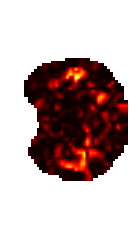

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline

scores_3d = scores.reshape((80, 80, 37))
plt.imshow(scores_3d[:, 55, :], origin='lower', cmap='hot')
plt.axis('off')
plt.show()

Thus, in the image above, brighter (more yellow) colors represent voxels with higher scores on the univariate test. If we subsequently apply (or "transform" in scikit-learn lingo) our X-matrix using, for example, the `select100best` selector, we'll select only the 100 "most yellow" (i.e. highest F-scores) voxels.

<div class='alert alert-info'>
**ToThink**: Given the image above, what is the major difference between data driven feature selection (like UFS) and ROI-based feature selection (e.g. only look at patterns in the amygdala) in terms of the spatial scale of patterns you'll select? Try to think of an example of UFS over ROI-based feature selection and vice versa.
</div>

Practically, after we've fit the transformer, we can call the `transform(X)` method that will actually select the subset according to the selector:

In [44]:
print("Shape of mvp.X before transform: %r ..." % (X.shape,))
X_after_ufs = select100best.transform(X)

print("... and shape of mvp.X after transform: %r." % (X_after_ufs.shape,))

Shape of mvp.X before transform: (40, 236800) ...
... and shape of mvp.X after transform: (40, 100).


As you can see, the transformer correctly selected a subset of 100 voxels from our X matrix! Now, both selectors were fit on the entire dataset, which is often course not how it should be done: because they use information from the labels (`y`), this step should be cross-validated. Thus, what you have to do is:

* fit your transformer on the train-set;
* transform your train-set;
* transform your test-set;
* (fit your model on the train-set;)
* (cross-validate to the test-set;)

We summarized the entire pipeline, including data partitioning (indexing), feature selection (transformation), and model fitting and their corresponding cross-validation steps in the image below:
<img src='sklearn_transformers.png'>

### 2.5.2 Feature extraction
There are many methods for feature extraction, like "downsampling" to ROI-averages (i.e. averaging voxel patterns in brain regions) and dimensionality-reduction techniques like PCA. Scikit-learn provides some of these techniques as "transformer" objects, which again have a `fit()` and `transform` method. In the next ToDo, you'll apply this!

<div class='alert alert-warning'>
**ToDo**: Below, we import the `PCA` class from scikit-learn. Check out the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html). Now, initialize an object from this `PCA`-class with the number of components to store set to 5, and subsequently fit in on `X` and subsequently call transform on `X` (note that you do not have to cross-validate this procedure!) and store the result in a new variable named `X_pca_transformed`. Then, check out the shape of `X_pca_transformed`: does this make sense?
</div>

In [45]:
from sklearn.decomposition import PCA

# initialize a PCA object ...

# ... call fit on X ...


# ... and call transform on X
X_pca_transformed = 

# And finally check out the shape of X_pca_transformed!


SyntaxError: invalid syntax (<ipython-input-45-78d6221b888e>, line 9)

In [ ]:
from sklearn.decomposition import PCA

# initialize a PCA object ...
pca = PCA()

# ... call fit on X ...
pca.fit(X=X)

# ... and call transform on X
X_pca_transformed = pca.transform(X)

# And finally check out the shape of X_pca_transformed!
X_pca_transformed.shape

Now, let's put everything you learned so far together and implement a fully cross-validated pipeline with UFS *and* model fitting/prediction!

<div class='alert alert-warning'>
**ToDo**: Below, we set up a K-fold cross-validation loop and prespecified a classifier (`clf`, a logistic regression model) and a transformer (`select50best`, selecting the 50 best features based upon an F-test). Now, it's up to you to actually implement the feature selection inside the for-loop. Make sure to fit the transformer only on the train-set, but then transform *both* the train-set and the test-set. Then, fit the model on the transformed train-set and cross-validate to the transformed test-set. Calculate accuracy of the cross-validated  model for each fold, and after all folds calculate the average accuracy (across folds).
</div>

In [46]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
folds = skf.split(X, y)

accuracy = []

select50best = SelectKBest(score_func=f_classif, k=50)

for fold in folds:
    
    train_idx, test_idx = fold
    
    # ToDo: make X_train, X_test, y_train, y_test
    
    # ToDo: call the select50best fit method (on X_train), and transform both X_train and X_test
    
    # ToDo: calculate accuracy

# ToDo: calculate average accuracy


In [47]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
folds = skf.split(X, y)

accuracy = []

select50best = SelectKBest(score_func=f_classif, k=50)

for fold in folds:
    
    train_idx, test_idx = fold
    
    # ToDo: make X_train, X_test, y_train, y_test
    X_train = X[train_idx,:]
    X_test = X[test_idx,:]
    y_train = y[train_idx]
    y_test = y[test_idx]
    
    # ToDo: call the select50best fit method (on X_train), and transform both X_train and X_test
    select50best.fit(X=X_train, y=y_train)
    X_train = select50best.transform(X=X_train)
    X_test = select50best.transform(X=X_test)
    
    # ToDo: calculate accuracy
    clf.fit(X=X_train, y=y_train)
    y_test_hat = clf.predict(X=X_test)
    accuracy.append(np.sum(y_test==y_test_hat)/len(y_test_hat))

# ToDo: calculate average accuracy
print('Mean accuracy: %.3f' % np.mean(accuracy))

/Users/steven/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     0      1      2 ..., 236797 236798 236799] are constant.
  UserWarning)
/Users/steven/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Mean accuracy: 0.873


### Optional: advanced cross-validation using Pipelines
(Recommended, but optional: only go through this section if you have time)

As you have seen in the previous assignment, the code within the K-fold for-loop becomes quite long (and messy) when you add a feature-selection step. Suppose you want to add another feature extraction step, like performing a PCA after an initial feature selection step. The code becomes even more obscure ...

Luckily, scikit-learn has an awesome solution for this: "Pipelines".

Pipelines are somewhat more advanced functionality within scikit-learn, but we wanted to show you guys because it really "cleans up" your code, and additionally, it is a great safeguard for accidental overfitting (e.g. when you accidentally perform feature-selection on all your data instead of only your train-data). 

Anyway, how does this work? Well, a picture it worth a thousand words, so check out the image below which schematically depicts what a pipeline does: <img src='pipelinesX.png'>

As you can see, a `Pipeline`-object "strings together" an arbitrary number of transformers (including "preprocessing" transformers like `StandardScaler`\*) and can optionally end in an estimator. Pipeline-objects have two (relevant) methods: `fit(X, y)` and `predict(X, y)` (the latter method only exists if there is an estimator in the pipeline). To use it, you only have to call `fit()` with `X_train` and `y_train` and it'll sequentially fit the transformers which will finally pass the transformed data to the estimator. Then, simply call `predict()` with `X_test` as argument and the pipeline will automatically cross-validate all fitted transformers, and eventually the estimator, on the `X_test` variable. 

Okay, lot's of info - let's break this down. First, let's initialize some transformers and an estimator:

------------
\* [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) is a scikit-learn transformer that does exactly the same as the `standardize()` method you implemented earlier! Strictly speaking, you don't need to cross-validate your standardization step, but it doesn't hurt either. 

In [48]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
ufs = SelectKBest(score_func=f_classif, k=1000)
pca = PCA(n_components=10)  # we want to reduce the features to 10 components
svc = SVC(kernel='linear')

Now, to initialize a Pipeline-object, we need to give it a list of tuples, in the first entry of each tuple is a name for the step in the pipeline and the second entry of each tuple is the actual transformer/estimator object. Let's do that for our pipeline:

In [49]:
from sklearn.pipeline import Pipeline

pipeline_to_make = [('preproc', scaler),
                    ('ufs', ufs),
                    ('pca', pca),
                    ('clf', svc)]

my_pipe = Pipeline(pipeline_to_make)

Let's test our pipeline-object (`my_pipe`) on our data. For this example, we'll use a simple hold-out cross-validation scheme (but pipelines are equally valuable in K-fold CV schemes!).

In [50]:
X_train, y_train = X[0::2], y[0::2]
X_test, y_test = X[1::2], y[1::2]

my_pipe.fit(X_train, y_train)
predictions = my_pipe.predict(X_test)
acc = np.mean(predictions == y_test)
print("Cross-validated accuracy on test-set: %.3f" % acc)

/Users/steven/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     0      1      2 ..., 236797 236798 236799] are constant.
  UserWarning)
/Users/steven/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Cross-validated accuracy on test-set: 0.850


Cool stuff huh? Quite efficient, I would say!

## 2.6 Assessing significance
Up to now, we examined the accuracy of decoding the experiment condition from fMRI data of a single subject. You probably achieved an accuracy score of approximately 85%. Next, we would like to know whether this accuracy score is *significantly* above chance.

First, let's take a moment to think about chance-level performance. 'Chance-level performance' refers to the predictive accuracy a model achieves if it does not use *any variance in patterns X*. When such a model makes predictions, it simply guesses. In situations with balanced designs (i.e., equal amounts of observations in both conditions), the accuracy would be 50% (in case of 2 conditions).

It's important to note that we have an *unbalanced* design: there were 32 'ACTIVE' trials versus just 8 'PASSIVE' trials. In this situation, a model that does not use the patterns in *X* can still learn that there are more observations of the majority class than of the minority class. Such a model would always predict the majority class (irrespective of the data X). In our experiment, a model (estimator) that just predicts the majority class ('ACTIVE') would be accurate in 80% of the predictions. Therefore, *chance-level* performance in this design is not 50% - but it is 80%!

With this in mind, let's see whether the decoding accuracy is significantly above chance - we know that the decoding accuracy of this participant is 85%, but this is a single participant of our sample. In order to make an inference about whether the decoding accuracy in the population is significantly higher than chance-level, we need to do a one-sample *t*-test. A *t*-test requires the mean (over folds!) accuracy score of all participants. Therefore, we must perform a decoding analysis pipeline for all our participants individually, and keep track of the accuracy scores.

<div class='alert alert-warning'>
**ToDo**: Before we start, we need to get the participant numbers of all our participants. To find these, we can make use of the directory names. In Section **1.3.1** you learned the tricks you need to get all subdirectory names of the `data` directory using a wildcard!

</div>

In [51]:
#
participant_numbers = # Fill in the right glob here!

# Next, we need to extract the participant numbers from the paths you just obtained. We do this for you here.
participant_numbers = [x.split('/')[-1] for x in participant_numbers]
print(participant_numbers)

SyntaxError: invalid syntax (<ipython-input-51-309dd128eca3>, line 2)

In [ ]:
# Example answer
participant_numbers = glob('../data/*')
print(participant_numbers)

# Next, we need to extract the participant numbers from the paths you just obtained. We do this for you here.
participant_numbers = [x.split('/')[-1] for x in participant_numbers]
print('\nThere are the participant numbers:\n%s' % participant_numbers)

We can now use this `participants_numbers` list to loop over the participant names!

<div class='alert alert-warning'>
**ToDo**: This ToDo is a big one, in which everything we learned so far comes together nicely. We will loop over all participants, implementing a cross-valdidated classification pipeline including feature selection. 

Make sure to include the following:

    1. Use 5-fold Stratified cross-validation
    2. Within each fold, select the best 50 features using an f_classif Selector
    3. Use a SVM to decode condition from these 50 features

</div>

In [52]:
# Keep track of all participants accuracies
all_accuracies = []

# Let's loop over the participants_numbers list
for participant_number in participant_numbers:
    
    # For each participant, get all tstat file paths. We did this for a single subject in Section 1.3.1!
    path_this_participant = '../data/' + participant_number + '/wm.feat/stats/*'
    t_stat_paths_this_participant = glob(path_this_participant)
    t_stat_paths_this_participant = sort_nifti_paths(t_stat_paths_this_participant) # remember to sort the paths!
    
    # Then, we need to create the pattern matrix X for each participant. Remember how we did this in Section 1.3.1?
    # For each participant, we need to get the data dimensions. Let's extract these from the nifti header. 
    voxel_dims = nib.load(t_stat_paths_this_participant[0]).header.get_data_shape()
    X = np.zeros((len(t_stat_paths_this_participant), np.prod(voxel_dims)))

    # Load the data of each trial separately. This was the last thing we did as part of Part 1.
    for trial, tstat_path in enumerate(t_stat_paths_this_participant):
        data = nib.load(tstat_path).get_data()
        data = data.ravel()
        X[trial,:] = data
    
    # Now, we have the fMRI patterns of a single participant loaded. Next, let's get y!
    onsets_df = pd.DataFrame(onsets, columns=['time', 'duration', 'condition'])
    onsets_df = onsets_df.sort_values(['condition', 'time'], ascending=[False, True]) # This step should not be necessary after new preprocessing
    y = onsets_df['condition'].values
    
    # All data of the current participant is now loaded! We can start the pattern analysis for this participant now

    
    # Let's use K-fold cross-validation for this participant
    skf = # ToDo: initialize a stratified K-fold class
    folds = # ToDo: use the skf-object to create the folds
    
    # Don't forget to initialize the actual estimator
    clf = # ToDo: initialize an SVC-object
    
    # Keep track of accuracies between folds
    accuracy_this_participant = []
    
    # Initialize the SelectKBest Selector with an f_classif score function
    select50best = #ToDo: initialize Selector

    # Loop over the folds
    for fold in folds:

        train_idx, test_idx = fold

        # ToDo: make X_train, X_test, y_train, y_test
        X_train =
        X_test =
        y_train =
        y_test =

        # ToDo: call the select50best fit method (on X_train), and transform both X_train and X_test
    
        # ToDo: fit your model on the train data
        model = clf.fit(X=X_train, y=y_train)
        
        # ToDo: predict the classes of your test data
        y_test_hat = model.predict(X=X_test)
        
        # ToDo: calculate the accuracy in this fold
        accuracy_this_fold = 
        accuracy_this_participant.append(accuracy_this_fold)

    # ToDo: calculate average accuracy (mean across folds!)
    mean_accuracy_this_participant = #ToDo
    print('Mean accuracy for participant %s: %.3f' % (participant_number, mean_accuracy_this_participant))
    all_accuracies.append(mean_accuracy_this_participant)

print('Final accuracy score mean: %.3f' % np.mean(all_accuracies))

SyntaxError: invalid syntax (<ipython-input-52-641b637e47ac>, line 32)

In [58]:
# Keep track of all participants accuracies
all_accuracies = []

# Let's loop over the participants_numbers list
for participant_number in participant_numbers:
    
    # For each participant, get all tstat file paths. We did this for a single subject in Section 1.3.1!
    path_this_participant = '../data/' + participant_number + '/wm.feat/stats/*'
    t_stat_paths_this_participant = glob(path_this_participant)
    t_stat_paths_this_participant = sort_nifti_paths(t_stat_paths_this_participant) # remember to sort the paths!
    
    # Then, we need to create the pattern matrix X for each participant. Remember how we did this in Section 1.3.1?
    # For each participant, we need to get the data dimensions. Let's extract these from the nifti header. 
    voxel_dims = nib.load(t_stat_paths_this_participant[0]).header.get_data_shape()
    X = np.zeros((len(t_stat_paths_this_participant), np.prod(voxel_dims)))

    # Load the data of each trial separately. This was the last thing we did as part of Part 1.
    for trial, tstat_path in enumerate(t_stat_paths_this_participant):
        data = nib.load(tstat_path).get_data()
        data = data.ravel()
        X[trial,:] = data
    
    # Now, we have the fMRI patterns of a single participant loaded. Next, let's get y!
    onsets_df = pd.DataFrame(onsets, columns=['time', 'duration', 'condition'])
    onsets_df = onsets_df.sort_values(['condition', 'time'], ascending=[False, True]) # This step should not be necessary after new preprocessing
    y = onsets_df['condition'].values
    
    # All data of the current participant is now loaded! We can start the pattern analysis for this participant now

    
    # Let's use K-fold cross-validation for this participant
    skf = StratifiedKFold(n_splits=5)
    folds = skf.split(X=X, y=y)
    
    # Don't forget to initialize the actual estimator
    clf = SVC(kernel='linear')
    
    # Keep track of accuracies between folds
    accuracy_this_participant = []
    
    # Initialize the SelectKBest Selector with an f_classif score function
    select50best = SelectKBest(f_classif, 50) #ToDo: initialize Selector

    # Loop over the folds
    for fold in folds:

        train_idx, test_idx = fold

        # ToDo: make X_train, X_test, y_train, y_test
        X_train = X[train_idx,:]
        X_test = X[test_idx,:]
        y_train = y[train_idx]
        y_test = y[test_idx]

        # ToDo: call the select50best fit method (on X_train), and transform both X_train and X_test
        select50best.fit(X=X_train, y=y_train)
        X_train = select50best.transform(X_train)
        X_test = select50best.transform(X_test)
        
        # ToDo: fit your model on the train data
        model = clf.fit(X=X_train, y=y_train)
        
        # ToDo: predict the classes of your test data
        y_test_hat = model.predict(X=X_test)
        
        # ToDo: calculate the accuracy in this fold
        accuracy_this_fold = np.mean(y_test_hat==y_test)
        accuracy_this_participant.append(accuracy_this_fold)

    # ToDo: calculate average accuracy (mean across folds!)
    mean_accuracy_this_participant = np.mean(accuracy_this_participant)
    print('Mean accuracy for participant %s: %.3f' % (participant_number, mean_accuracy_this_participant))
    all_accuracies.append(mean_accuracy_this_participant)

print('Final accuracy score mean: %.3f' % np.mean(all_accuracies))

/Users/steven/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     0      1      2 ..., 236797 236798 236799] are constant.
  UserWarning)
/Users/steven/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Mean accuracy for participant pi0031: 0.908
Mean accuracy for participant pi0036: 0.902
Mean accuracy for participant pi0041: 0.829


/Users/steven/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     0      1      2 ..., 230397 230398 230399] are constant.
  UserWarning)


Mean accuracy for participant pi0046: 0.978
Mean accuracy for participant pi0051: 0.750
Mean accuracy for participant pi0056: 0.880
Mean accuracy for participant pi0061: 0.725
Mean accuracy for participant pi0066: 0.898
Mean accuracy for participant pi0071: 0.918
Mean accuracy for participant pi0081: 0.873
Mean accuracy for participant pi0086: 0.896
Mean accuracy for participant pi0091: 0.753
Mean accuracy for participant pi0096: 0.956
Mean accuracy for participant pi0101: 0.867
Mean accuracy for participant pi0106: 0.804
Final accuracy score mean: 0.862


If everything went well, you now have a list `all_accuracies` which contains the accuracies (mean over folds) of all participants! This is all data we need to do a one-sample t-test.

The one-sample t-test is implemented in the Python package Scipy. Let's load it first

In [59]:
from scipy.stats import ttest_1samp

The function requires two arguments: the vector of values to test, and the hypothesized population mean. In our case, the data vector is `all_accuracies`, and the population mean is 0.80. If done correctly, the `ttest_1samp` function returns a tuple of the t-value and the p-value.

<div class='alert alert-warning'>
**ToDo**: Do the one-sample t-test! Can we decode the condition with a significantly above-chance accuracy?

</div>

In [60]:
# Example answer
t, p = ttest_1samp(all_accuracies, 0.8)
print('The t-value is %.3f, with a p-value of %.5f' % (t, p))

The t-value is 3.202, with a p-value of 0.00639


Finally, we can draw our conclusions: can we decode trial condition, using the fMRI data, with an above-chance accuracy?

### Congratulations! You've reached the end of this tutorial

We hope you enjoyed the workshop. It should be stressed that these are really the basics of MVPA - every step that was introduced warrants it own workshop (feature selection, feature building, model selection, significance testing - and much more that we did not discuss such as regularization, hyperparameter optimization, and grid searches). You are encouraged to discover what's possible with MVPA on your own!

Additional resources that may help:
- [`scikit-learn`](http://scikit-learn.org/stable/index.html)
- [`skbold`](https://github.com/lukassnoek/skbold)
- ...

Good luck using MVPA!